In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Models import GaussianPulse as G
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

h_red = Const.Planck_reduced_ev_fs
h = Const.Planck_ev_fs
light_speed = Const.Light_speed_nm_fsm1

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,executable='yambo_rt',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Analysis of the NEQ dynamics

We study the non-equilibrium dynamics of the system

## Removal of the symmetries broken by the pulse

We perform the FixSymm procedure and remove the symmetries broken by a pulse with 
linear polarization along the $x$ axis. 

We build the run_dir associated to all the $k$-samplings considered in the EQ analysis

In [4]:
run_path = 'NEQ_RT'
kpoints = ['12x12x3']

In [6]:
for k in kpoints: 
    #source_dir = os.path.join(core_dbs,k,'SAVE')
    source_dir = os.path.join('DFT_analysis/kpoints_%s-nbnds_100.save'%k,'SAVE')
    run_dir = os.path.join(run_path,k)
    rt_run_dir = os.path.join(run_dir,'FixSymm')

    Tools.init_yambo_run_dir(source_dir,run_dir=run_dir)
    if not os.path.isdir(rt_run_dir):    
        fixSymm_inp = Tools.build_FixSymm_input(run_dir,polarization='linear')
        ypp_code = C.YamboCalculator(C.RunRules(),executable='ypp')
        ypp_code.run(input=fixSymm_inp,name='FixSymm',run_dir=run_dir)
        Tools.build_r_setup(rt_run_dir)

Create folder path NEQ_RT/12x12x3
Create a symlink of DFT_analysis/kpoints_12x12x3-nbnds_100.save/SAVE in NEQ_RT/12x12x3
Build the r_setup in the run_dir path NEQ_RT/12x12x3
Initialize a Yambo calculator with scheduler direct
run command: mpirun -np 1 ypp -F FixSymm.in -J FixSymm -C FixSymm
computation FixSymm is running...
computation FixSymm ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Run performed in 10s
Build the r_setup in the run_dir path NEQ_RT/12x12x3/FixSymm


## Analysis of the pump pulse

We set the pulse field and we show its Fourier transform together with the (IP) absorption.

The pulse is set to a wavelenght of 800 nm that corresponds to 1.55 eV and has a fwhm of 35 fs.

In [7]:
l = 800 # nm
light_speed*h/l

1.5498024800687957

In [8]:
time_range = 1000 # fs
time = np.linspace(0,time_range,5*(time_range+1))
pulse_energy = 1.55 # eV
fwhm = 35 # fs

In [9]:
pulse = G.gaussianPulse(time,energy=pulse_energy,fwhm=fwhm)

time unit: fs - energy unit: eV
period of the oscillations 2.66817270789182 fs
width of the pulse 14.863131505040334 fs
fwhm of the pulse 35 fs


(0.0, 200.0)

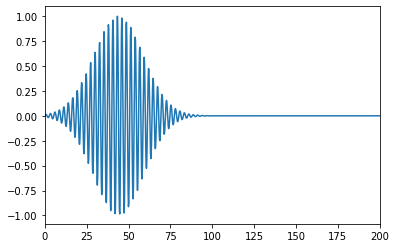

In [10]:
plt.plot(time,pulse)
plt.xlim(0,200)

In [11]:
pulse_freq,pulse_ft = G.evalPulseFourierTransform(time,pulse)

time unit: fs - energy unit: eV
energy resolution of the FT: 0.004134841388768031 eV
maximum energy: 10.341238313308846 eV
FWHM of the FT of the pulse: 0.09923619333043288 eV


In [14]:
alpha_exp= 'Experiment/alpha.dat'
data = np.loadtxt(alpha_exp,delimiter=',').T
energy_alpha,alpha_exp = data

abs_file = 'EQ_ABS/12x12x3/bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3/o-bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3.eps_q1_haydock_bse'
data = P.YamboOutputParser.from_file(abs_file)['eps_q1_haydock_bse']
energy = data['energy']
eps_im = data['eps_imag']
eps_o_im = data['eps_o_imag']
alpha = eps_im*energy
alpha_o = eps_o_im*energy

Parse file EQ_ABS/12x12x3/bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3/o-bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3.eps_q1_haydock_bse


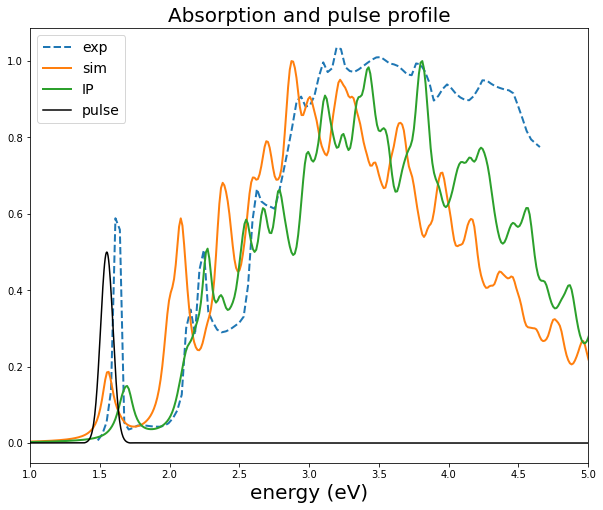

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(energy_alpha,alpha_exp,label='exp',linestyle='--',linewidth=2)
ax.plot(energy,alpha/max(alpha),label='sim',linewidth=2) 
ax.plot(energy,alpha_o/max(alpha_o),label='IP',linewidth=2) 
ax.plot(pulse_freq,pulse_ft/max(2*pulse_ft),c='black',label='pulse')
ax.set_xlim(1,5)
#ax.set_ylabel(r'$\alpha$',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_title('Absorption and pulse profile',size=20)
ax.legend(fontsize=14)

## NEQ Analysis

We study the time evolution of the carriers.

We select a $k$-samplings

In [7]:
run_path = 'NEQ_RT'
k = '12x12x3'

In [8]:
run_dir = os.path.join(run_path,k,'FixSymm')
run_dir

'NEQ_RT/12x12x3/FixSymm'

The ems1s database has to be computed ex novo due to the FixSymm procedure.

In [86]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXs = 200 # (RL) G size of the response function
NGsBlkXs_units = 'RL'
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -X s',folder=run_dir)
inp.set_array_variables(units=NGsBlkXs_units,NGsBlkXs=NGsBlkXs)
inp.set_array_variables(BndsRnXs=BndsRnXs,LongDrXs=elec_field)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.32') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
#inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.4.4.2') # for 1 node on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
idd = 'em1s-ngsblkxs_%s-bndsrnxs_%s'%(NGsBlkXs,BndsRnXs[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

16 2
Initialize a Dataset with 1 parallel tasks


In [87]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'NEQ_RT/12x12x3/FixSymm',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -X s',
  'folder': 'NEQ_RT/12x12x3/FixSymm',
  'filename': 'yambo.in',
  'arguments': ['em1s'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'NGsBlkXs': [200, 'RL'],
   'Chimod': 'HARTREE',
   'XTermKind': 'none',
   'BndsRnXs': [[1, 100], ''],
   'LongDrXs': [[1.0, 0.0, 0.0], ''],
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '1.1.32',
   'X_and_IO_ROLEs': 'q.g.k.c.v',
   'X_and_IO_CPU': '1.1.1.16.2'}},
 'name': 'em1s-ngsblkxs_200-bndsrnxs_100'}

In [88]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F em1s-ngsblkxs_200-bndsrnxs_100.in -J em1s-ngsblkxs_200-bndsrnxs_100 -C em1s-ngsblkxs_200-bndsrnxs_100
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_em1s-ngsblkxs_200-bndsrnxs_100.sh
computation em1s-ngsblkxs_200-bndsrnxs_100 is running...
computation em1s-ngsblkxs_200-bndsrnxs_100 ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Run performed in 19m-33s
Task [0] ended 
 


Now we peform a RT simulation

In [10]:
n_tasks = ntasks_per_node*nodes

field_int = 1e7 # intensity of the pulses in kW/cm^2
fwhm = 35 # fs 
energy = 1.55 # eV
time_step = 10 # as
sim_time = 150 # fs
bands = [51,54] # [49,56] #[49,54] #[51,56] #  
scissor = 0.261
eta = 0.05 # eV
io_time = [10.0,10.0,1.]  # I/O (CARRIERs - GF - OUTPUT) in fs 
io_cache_time = [1.,10.] # Time between two consecutive (caching - I/O) of OBSERVABLES in fs

study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(ntasks)
#inp.set_scalar_variables(DBsIOoff='obs GF CARRIERs') # do not write these ndbs on disk
inp.set_rt_field(int=field_int,fwhm=fwhm,polarization='linear',freq=energy)
idd = 'ip_field-int_%s-energy_%s-bands_%s-%s'%(field_int,energy,bands[0],bands[1])
study.append_run(id=idd,input=inp,runner=code)

inp = I.YamboInput('yambo_rt -n p -v hsex -e -V rt',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(k=16,b=4) # 2 nodes - 64 mpi
inp.set_array_variables(COLLBands=bands)
inp.set_scalar_variables(HXC_Potential='SEX+HARTREE')
inp.set_rt_field(int=field_int,fwhm=fwhm,polarization='linear',freq=energy)
idd = 'sex_field-int_%s-energy_%s-bands_%s-%s'%(field_int,energy,bands[0],bands[1])
study.append_run(id=idd,input=inp,runner=code,jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100'])

Initialize a Dataset with 1 parallel tasks


In [11]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'NEQ_RT/12x12x3/FixSymm',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo_rt -n p -v ip -V rt',
  'folder': 'NEQ_RT/12x12x3/FixSymm',
  'filename': 'yambo.in',
  'arguments': ['life', 'negf'],
  'variables': {'RT_Threads': [0.0, ''],
   'HARRLvcs': [38691.0, 'RL'],
   'GfnRT_N': [1.0, ''],
   'dTupdateTime': [0.0, 'fs'],
   'dTupdateTimeSet': [-0.024189, 'fs'],
   'dTupdateJump': [0.0, 'fs'],
   'dTupdateTresh': [0.1, ''],
   'dT_MAX': [-1.0, 'fs'],
   'dT_SET': [0.0, ''],
   'ScattTresh': [-1.0, 'eV'],
   'RADLifeTime': [0.0, 'fs'],
   'RADmagnific': [1.0, ''],
   'PhLifeTime': [0.0, 'fs'],
   'DephEThresh': [0.000272114, 'eV'],
   'RTstep': [10, 'as'],
   'NETime': [150, 'fs'],
   'Field1_NFreqs': [1.0, ''],
   'Field1_DFreq': [0.0, 'eV'],
   'Field1_Int': [20000000.0, 'kWLm2'],
   'Field1_Width': [0.0, 'fs'],
   'Field1_FWHM': [35, 'fs'],
   'Field1_Tstart': [0.0, 'fs'],
   'HXC_Potential': 'IP',
   'GfnRTdb': 'none',
   '

In [12]:
results = study.run(selection=[0])

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F ip_field-int_20000000.0-energy_1.55-bands_49-56.in -J ip_field-int_20000000.0-energy_1.55-bands_49-56 -C ip_field-int_20000000.0-energy_1.55-bands_49-56
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_ip_field-int_20000000.0-energy_1.55-bands_49-56.sh
computation ip_field-int_20000000.0-energy_1.55-bands_49-56 is running...
computation ip_field-int_20000000.0-energy_1.55-bands_49-56 ended
Run performed in 19s
Task [0] ended 
 


Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

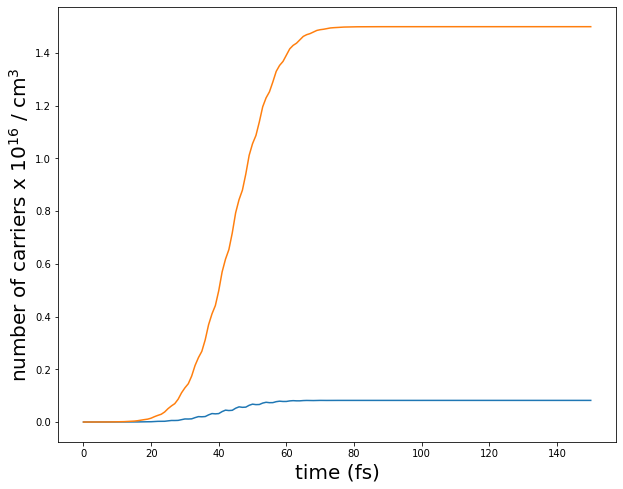

In [130]:
# bands 49-56
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

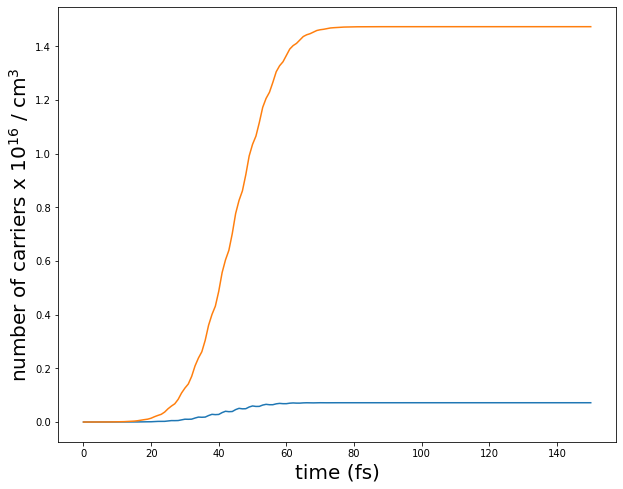

In [117]:
# bands 49-54
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

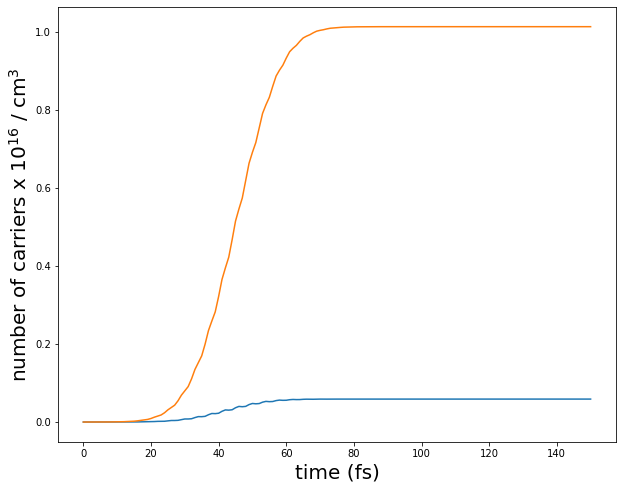

In [108]:
# bands 51-56
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

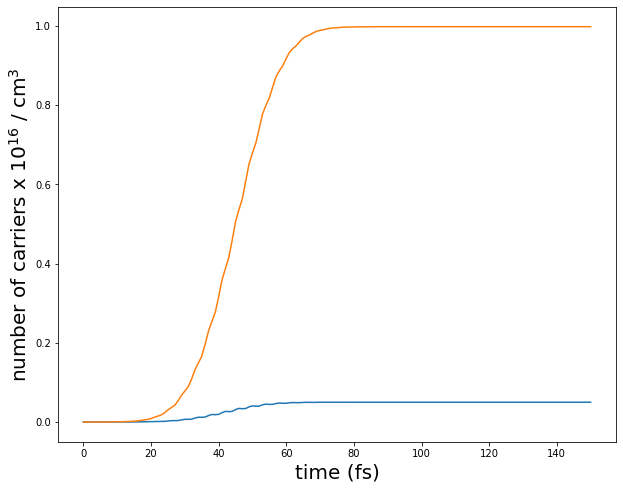

In [135]:
# bands 51-54
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

On the basis of this analysis we observe that the bands from 49 to 54 are sufficient to describe
the absorption at 1.55 eV

Now we perform RT simulations in function of the field intensity to test the linear response range

In [15]:
n_tasks = ntasks_per_node*nodes

field_int = [1e7,2e7,5e7,1e8,5e8,1e9] # intensity of the pulses in kW/cm^2
fwhm = 35 # fs 
energy = 1.55 # eV
time_step = 10 # as
sim_time = 150 # fs
bands =  [49,54] #[49,56]  
scissor = 0.261
eta = 0.05 # eV
io_time = [10.0,10.0,1.]  # I/O (CARRIERs - GF - OUTPUT) in fs 
io_cache_time = [1.,10.] # Time between two consecutive (caching - I/O) of OBSERVABLES in fs

study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -n p -v hsex -e -V rt',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(k=16,b=4) # 2 nodes - 64 mpi
#inp.set_rt_cpu(k=16,b=2) # 1 node - 32 mpi
inp.set_array_variables(COLLBands=bands)
inp.set_scalar_variables(HXC_Potential='SEX+HARTREE')
for f in field_int:
    inp.set_rt_field(int=f,fwhm=fwhm,polarization='linear',freq=energy)
    idd = 'sex_field-int_%s-energy_%s-bands_%s-%s'%(f,energy,bands[0],bands[1])
    #idd = 'test'
    study.append_run(id=idd,input=inp,runner=code,jobname=[idd,
        'em1s-ngsblkxs_200-bndsrnxs_100','ndb_dipoles-coll-bands_%s-%s'%(bands[0],bands[1])])

Initialize a Dataset with 1 parallel tasks


In [16]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'NEQ_RT/12x12x3/FixSymm',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo_rt -n p -v hsex -e -V rt',
  'folder': 'NEQ_RT/12x12x3/FixSymm',
  'filename': 'yambo.in',
  'arguments': ['life', 'collisions', 'negf'],
  'variables': {'RT_Threads': [0.0, ''],
   'HARRLvcs': [38691.0, 'RL'],
   'EXXRLvcs': [38691.0, 'RL'],
   'CORRLvcs': [38691.0, 'RL'],
   'GfnRT_N': [1.0, ''],
   'dTupdateTime': [0.0, 'fs'],
   'dTupdateTimeSet': [-0.024189, 'fs'],
   'dTupdateJump': [0.0, 'fs'],
   'dTupdateTresh': [0.1, ''],
   'dT_MAX': [-1.0, 'fs'],
   'dT_SET': [0.0, ''],
   'ScattTresh': [-1.0, 'eV'],
   'RADLifeTime': [0.0, 'fs'],
   'RADmagnific': [1.0, ''],
   'PhLifeTime': [0.0, 'fs'],
   'DephEThresh': [0.000272114, 'eV'],
   'RTstep': [10, 'as'],
   'NETime': [150, 'fs'],
   'Field1_NFreqs': [1.0, ''],
   'Field1_DFreq': [0.0, 'eV'],
   'Field1_Int': [10000000.0, 'kWLm2'],
   'Field1_Width': [0.0, 'fs'],
   'Field1_FWHM': [35, 'fs'],
  

In [17]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F test.in -J "test,em1s-ngsblkxs_200-bndsrnxs_100,ndb_dipoles-coll-bands_49-54" -C test
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_test.sh
computation test is running...
computation test ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
game_over string not found in report. Check the computation!
Task [0] ended 
 


In [9]:
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

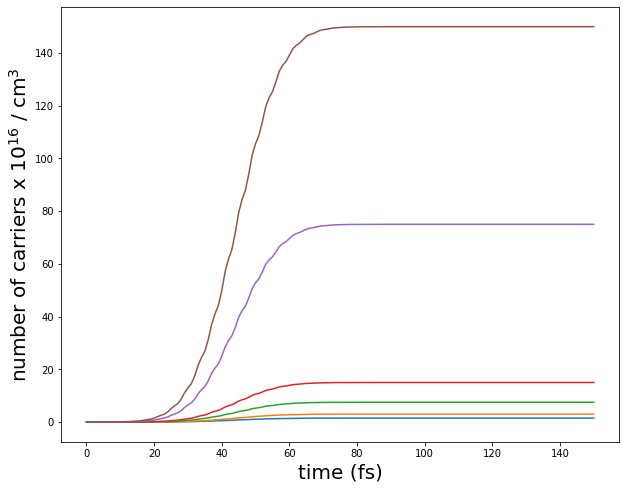

In [10]:
# bands 49-56
fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

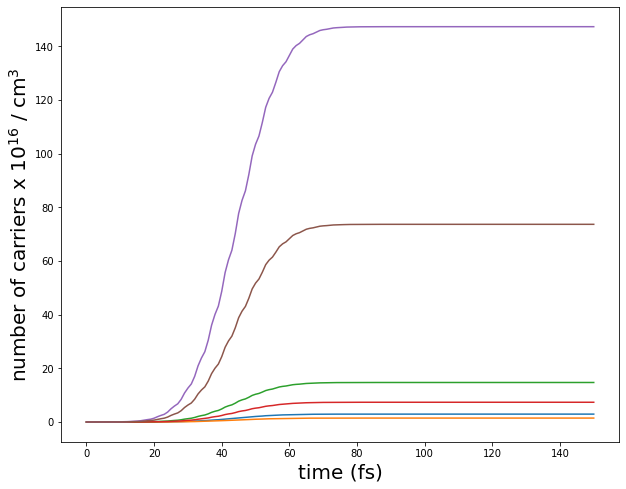

In [170]:
# bands 49-54
fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

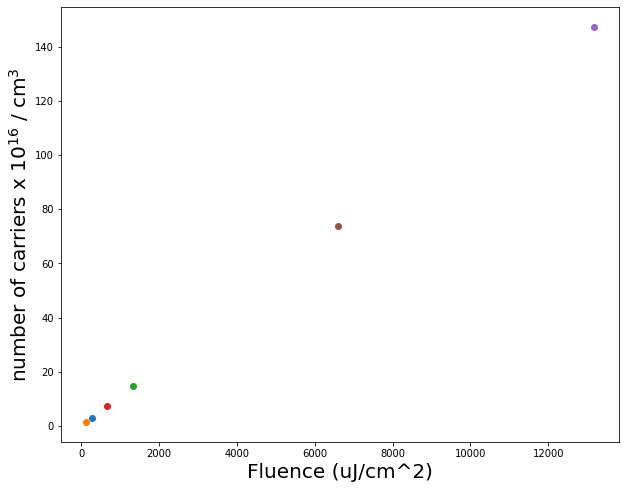

In [171]:
# bands 49-54
fluence,carriers = [],[]

for r in results.values():
    data = r.data['external_field']
    fluence.append(data['Fluence'][-1]/1e3)             
    data = r.data['carriers']
    carriers.append(data['dne'][-1]/vol_direct/1e16)

fig, ax = plt.subplots(figsize=(10, 8))

for f,c in zip(fluence,carriers):
    ax.scatter(f,c)
ax.set_xlabel('Fluence (uJ/cm^2)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

## Analysis of the k and time resolved occupations

In [12]:
from mppi.Utilities.Utils import file_parser

We select a $k$-samplings

In [13]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32
cpus_per_task=1
omp_num_threads=1

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp_rt',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [14]:
run_path = 'NEQ_RT'
k = '12x12x3'
run_dir = os.path.join(run_path,k,'FixSymm')
scissor = 0.261

# The coordinates of the high sym points are provided in crystal coordinates
# to match the 'rlu' in the ypp inpuy
G = [0.,0.,0.]
K = [1./3.,1./3.,0.]
M = [0.5,0.,0.]
high_sym = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path

In [15]:
bands_step = 50
scissor = 0.261 # eV

inp = I.YamboInput('ypp_rt -rtplot o -rtmode b -V All',folder=run_dir,filename='ypp_rt.in')
inp['arguments'].append('IncludeEQocc')
inp.set_array_variables(units='fs',TimeStep=50)
inp.set_array_variables(BANDS_steps=bands_step,GfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ')
inp

{'args': 'ypp_rt -rtplot o -rtmode b -V All',
 'folder': 'NEQ_RT/12x12x3/FixSymm',
 'filename': 'ypp_rt.in',
 'arguments': ['RToccupations', 'RTfitbands', 'IncludeEQocc'],
 'variables': {'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'StdoHash': [40.0, ''],
  'PROJECT_depth': [1.0, ''],
  'PROJECT_threshold': [5.0, ''],
  'INTERP_Shell_Fac': [20.0, ''],
  'INTERP_NofNN': [1.0, ''],
  'OutputAlat': [0.0, ''],
  'NelFac': [1.0, ''],
  'BANDS_steps': [50, ''],
  'TimeStep': [50, 'fs'],
  'PROJECT_mode': 'none',
  'INTERP_mode': 'BOLTZ',
  'cooIn': 'rlu',
  'cooOut': 'rlu',
  'CIRCUIT_E_DB_path': 'none',
  'TimeRange': [['-1.000000', '-1.000000'], 'fs'],
  'GfnQP_E': [[0.261, 1.0, 1.0], ''],
  'BANDS_path': 'G M K G'}}

In [19]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
#study.set_postprocessing_function(PP.yambo_parse_data)

#idd = 'ypp_rt-test_bands'
idd = 'ypp_rt-test_bands-ip'
#idd = 'ypp_rt-test_dos'
#study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'sex_field-int_20000000.0-energy_1.55-bands_49-56'])
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'ip_field-int_20000000.0-energy_1.55-bands_49-56'])

Initialize a Dataset with 1 parallel tasks


In [7]:
#study.runs[0]

In [21]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: NEQ_RT/12x12x3/FixSymm/job_ypp_rt-test_bands-ip.out
delete folder: NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands-ip
run command: mpirun -np 32 ypp_rt -F ypp_rt-test_bands-ip.in -J "ypp_rt-test_bands-ip,ip_field-int_20000000.0-energy_1.55-bands_49-56" -C ypp_rt-test_bands-ip
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_ypp_rt-test_bands-ip.sh
computation ypp_rt-test_bands-ip is running...
computation ypp_rt-test_bands-ip ended
Run performed in 02s
Task [0] ended 
 


We create a BandStructure object using a ypp computation with the same parameters of this one

In [9]:
ypp_data = 'BANDS/12x12x3/ypp_bands_dft_rt-parameters/o-ypp_bands_dft_rt-parameters.bands_interpolated'
ypp_bands = U.BandStructure.from_Ypp_file(ypp_data,high_sym)

In [11]:
#ypp_bands.get_kpath()

We parse the ypp_rt results (at given time) and we plot the RT occupations over the EQ bands

In [12]:
f = 'NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands/o-ypp_rt-test_bands.YPP-RT_occ_bands_T_150.0000'
numBands = 8
data = file_parser(f)
data.shape

(5, 1208)

In [14]:
kpath = ypp_bands.get_kpath() #np.array_split(data[0],numBands)[0]
bands = np.array_split(data[1],numBands)
occ = np.array_split(data[2],numBands)

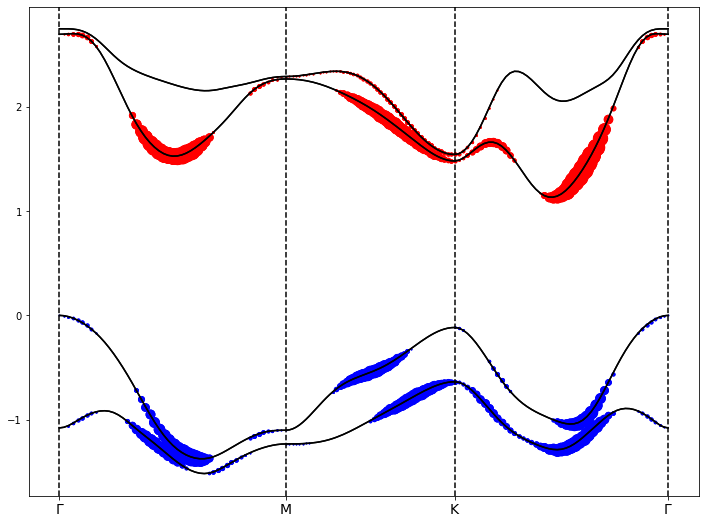

In [15]:
fig, ax = plt.subplots(figsize=(12, 9))
ypp_bands.plot(plt,linestyle='-',c='black')

for ind_b in range(len(bands)):
    for ind in range(len(kpath)):
        x,y,o = kpath[ind],bands[ind_b][ind],occ[ind_b][ind]
        if o < 0 : color = 'blue'
        if o >= 0 : color = 'red'
        plt.scatter(x,y,s=abs(int(5e7*o)),c=color)

We perform the same analysis also for the IP evolution

In [16]:
f = 'NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands-ip/o-ypp_rt-test_bands-ip.YPP-RT_occ_bands_T_150.0000'
numBands = 8
data = file_parser(f)
data.shape

(5, 1208)

In [17]:
kpath = ypp_bands.get_kpath() #np.array_split(data[0],numBands)[0]
bands = np.array_split(data[1],numBands)
occ = np.array_split(data[2],numBands)

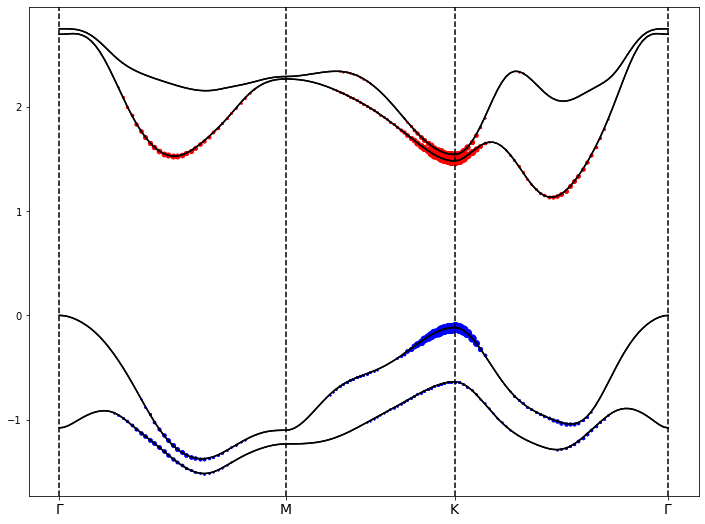

In [18]:
fig, ax = plt.subplots(figsize=(12, 9))
ypp_bands.plot(plt,linestyle='-',c='black')

for ind_b in range(len(bands)):
    for ind in range(len(kpath)):
        x,y,o = kpath[ind],bands[ind_b][ind],occ[ind_b][ind]
        if o < 0 : color = 'blue'
        if o >= 0 : color = 'red'
        plt.scatter(x,y,s=abs(int(5e7*o)),c=color)

We study the projection option of this postprocessing

In [69]:
bands_step = 50
scissor = 0.261 # eV

inp = I.YamboInput('ypp_rt -rtplot o -rtmode b -V All',folder=run_dir,filename='ypp_rt.in')
inp['arguments'].append('IncludeEQocc')
inp.set_array_variables(units='fs',TimeStep=50)
inp.set_array_variables(BANDS_steps=bands_step,GfnQP_E=[scissor,1.,1.]) 
inp.set_scalar_variables(BANDS_path='G M K',INTERP_mode='BOLTZ',PROJECT_mode='PLANE')
inp

{'args': 'ypp_rt -rtplot o -rtmode b -V All',
 'folder': 'NEQ_RT/12x12x3/FixSymm',
 'filename': 'ypp_rt.in',
 'arguments': ['RToccupations', 'RTfitbands', 'IncludeEQocc'],
 'variables': {'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'StdoHash': [40.0, ''],
  'PROJECT_depth': [1.0, ''],
  'PROJECT_threshold': [5.0, ''],
  'INTERP_Shell_Fac': [20.0, ''],
  'INTERP_NofNN': [1.0, ''],
  'OutputAlat': [0.0, ''],
  'NelFac': [1.0, ''],
  'BANDS_steps': [50, ''],
  'TimeStep': [50, 'fs'],
  'PROJECT_mode': 'PLANE',
  'INTERP_mode': 'BOLTZ',
  'cooIn': 'rlu',
  'cooOut': 'rlu',
  'CIRCUIT_E_DB_path': 'none',
  'TimeRange': [['-1.000000', '-1.000000'], 'fs'],
  'GfnQP_E': [[0.261, 1.0, 1.0], ''],
  'BANDS_path': 'G M K'}}

In [70]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
#study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'ypp_rt-test_bands-project_PLANE'
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'sex_field-int_20000000.0-energy_1.55-bands_49-56'])
#study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'ip_field-int_20000000.0-energy_1.55-bands_49-56'])

Initialize a Dataset with 1 parallel tasks


In [71]:
#study.runs[0]

In [72]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: NEQ_RT/12x12x3/FixSymm/job_ypp_rt-test_bands-project_PLANE.out
delete folder: NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands-project_PLANE
run command: mpirun -np 32 ypp_rt -F ypp_rt-test_bands-project_PLANE.in -J "ypp_rt-test_bands-project_PLANE,sex_field-int_20000000.0-energy_1.55-bands_49-56" -C ypp_rt-test_bands-project_PLANE
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_ypp_rt-test_bands-project_PLANE.sh
computation ypp_rt-test_bands-project_PLANE is running...
computation ypp_rt-test_bands-project_PLANE ended
Run performed in 02s
Task [0] ended 
 


We parse and analyze the o-files with the results

In [73]:
file = 'NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands-project_PLANE/o-ypp_rt-test_bands-project_PLANE.occupations_electrons_projected_PLANE_T_150.0000'
numk = bands_step+1
data = file_parser(file)
data.shape

(3, 2601)

In [81]:
Kx = np.array([data[0,numk*ind] for ind in range(numk)])
Ky = np.array([data[1,ind] for ind in range(numk)])
occ = np.reshape(data[2],(numk,numk))
Kx,Ky

(array([ 0.        , -0.00685051, -0.01370101, -0.02055152, -0.02740207,
        -0.03425257, -0.04110308, -0.04795358, -0.05480409, -0.0616546 ,
        -0.06850514, -0.07535565, -0.08220615, -0.08905666, -0.09590716,
        -0.10275768, -0.10960817, -0.11645872, -0.12330923, -0.13015974,
        -0.13701025, -0.14386076, -0.1507113 , -0.15756179, -0.16441231,
        -0.17126282, -0.17811331, -0.18496382, -0.19181432, -0.19866484,
        -0.20551536, -0.2123659 , -0.21921641, -0.2260669 , -0.23291744,
        -0.23976794, -0.24661846, -0.25346896, -0.26031947, -0.26716995,
        -0.27402049, -0.28087103, -0.28772151, -0.29457203, -0.30142254,
        -0.30827308, -0.31512359, -0.3219741 , -0.32882458, -0.33567512,
        -0.34252563]),
 array([0.        , 0.0022835 , 0.00456701, 0.00685052, 0.00913402,
        0.01141752, 0.01370103, 0.01598454, 0.01826803, 0.02055154,
        0.02283504, 0.02511855, 0.02740205, 0.02968556, 0.03196906,
        0.03425256, 0.03653606, 0.03881958,

In [82]:
Kx.shape,Ky.shape,occ.shape

((51,), (51,), (51, 51))

We have to understand which is the meaning of the Kx and Ky coordinates. From the o- we know that

In [83]:
x_versor = np.array([-0.506847322,-0.292628467])
y_versor = np.array([-0.168949097,0.292628467])

In [85]:
Kx_cart = Kx*x_versor[0]+Ky*y_versor[0]
Ky_cart = Kx*x_versor[1]+Ky*y_versor[0]
Kx_cart,Ky_cart

(array([-0.        ,  0.00308637,  0.00617273,  0.00925909,  0.01234548,
         0.01543184,  0.01851821,  0.02160457,  0.02469094,  0.0277773 ,
         0.03086369,  0.03395005,  0.03703642,  0.04012278,  0.04320914,
         0.04629552,  0.04938187,  0.05246826,  0.05555463,  0.05864099,
         0.06172736,  0.06481372,  0.06790011,  0.07098646,  0.07407283,
         0.0771592 ,  0.08024556,  0.08333193,  0.08641828,  0.08950466,
         0.09259103,  0.09567741,  0.09876378,  0.10185014,  0.10493652,
         0.10802288,  0.11110925,  0.11419561,  0.11728198,  0.12036833,
         0.12345471,  0.12654109,  0.12962744,  0.13271381,  0.13580018,
         0.13888656,  0.14197293,  0.1450593 ,  0.14814565,  0.15123203,
         0.1543184 ]),
 array([-0.        ,  0.00161886,  0.00323771,  0.00485657,  0.00647544,
         0.0080943 ,  0.00971315,  0.01133201,  0.01295087,  0.01456973,
         0.01618859,  0.01780745,  0.01942631,  0.02104516,  0.02266402,
         0.02428288,  0.0259

In [78]:
M_coord = np.array([-0.34252563,0.])
Mx_cart = M_coord[0]*x_versor[0]+M_coord[1]*y_versor[0]
My_cart = M_coord[0]*x_versor[1]+M_coord[1]*y_versor[1]
Mx_cart,My_cart

(0.17360819828186289, 0.10023275001510921)

In [87]:
KK_coord = np.array([-0.342525661,0.114175245])
KKx_cart = KK_coord[0]*x_versor[0]+KK_coord[1]*y_versor[0]
KKy_cart = KK_coord[0]*x_versor[1]+KK_coord[1]*y_versor[1]
KKx_cart,KKy_cart

(0.1543184094516261, 0.13364368600029108)

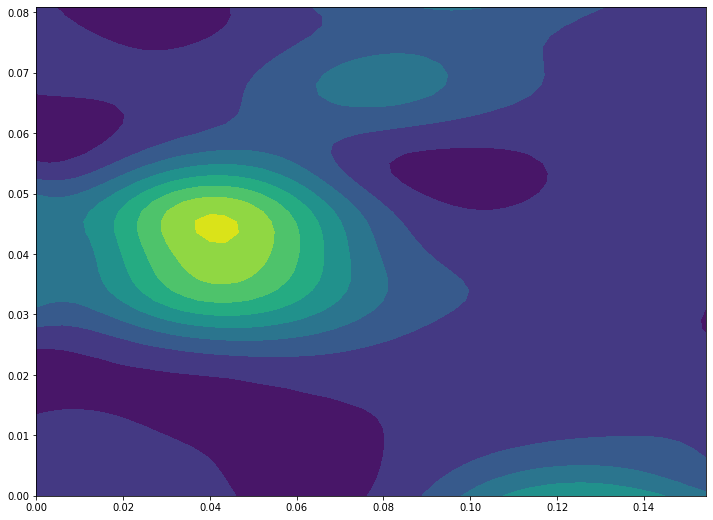

In [86]:
fig, ax = plt.subplots(figsize=(12, 9))

plt.contourf(Kx_cart,Ky_cart,occ)

In [ ]:
#################################################################################

We perform the ypp_rt postprocessing to extract the DOS

In [11]:
bands_step = 50
scissor = 0.261 # eV

inp = I.YamboInput('ypp_rt -rtplot o -rtmode d -V All',folder=run_dir,filename='ypp_rt.in')
inp['arguments'].append('IncludeEQocc')
inp.set_array_variables(units='fs',TimeStep=50)
inp.set_array_variables(BANDS_steps=bands_step,GfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ')
inp.set_array_variables(units='eV',DOSERange=[-3,3])
inp

{'args': 'ypp_rt -rtplot o -rtmode d -V All',
 'folder': 'NEQ_RT/12x12x3/FixSymm',
 'filename': 'ypp_rt.in',
 'arguments': ['RToccupations', 'IncludeEQocc'],
 'variables': {'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'StdoHash': [40.0, ''],
  'INTERP_Shell_Fac': [20.0, ''],
  'INTERP_NofNN': [1.0, ''],
  'TimeStep': [50, 'fs'],
  'DOSESteps': [500.0, ''],
  'DOS_broad': [0.1, 'eV'],
  'GfnQP_INTERP_NN': [1.0, ''],
  'GfnQP_INTERP_shells': [20.0, ''],
  'GfnQP_Wv_E': [0.0, 'eV'],
  'GfnQP_Wv_dos': [0.0, 'eV'],
  'GfnQP_Wc_E': [0.0, 'eV'],
  'GfnQP_Wc_dos': [0.0, 'eV'],
  'INTERP_mode': 'BOLTZ',
  'GfnQPdb': 'none',
  'GfnQP_DbGd_INTERP_mode': 'NN',
  'GfnQP_Z': [(1+0j), ''],
  'INTERP_Grid': [['-1', '-1', '-1'], ''],
  'TimeRange': [['-1.000000', '-1.000000'], 'fs'],
  'DOSERange': [[-3, 3], 'eV'],
  'PDOS_atoms': [['-1', '-1'], ''],
  'PDOS_kinds': [['-1', '-1'], ''],
  'PDOS_wfcs': [['-1', '-1'], ''],
  'PDOS_l': [['-1', '-1'], ''],
  'PDOS_j': [['-1.000000', '-1.000000'], 

In [12]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
#study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'ypp_rt-test_dos'
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'sex_field-int_20000000.0-energy_1.55-bands_49-56'])
#study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'ip_field-int_20000000.0-energy_1.55-bands_49-56'])

Initialize a Dataset with 1 parallel tasks


In [15]:
#study.runs[0]

In [14]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 ypp_rt -F ypp_rt-test_dos.in -J "ypp_rt-test_dos,sex_field-int_20000000.0-energy_1.55-bands_49-56" -C ypp_rt-test_dos
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_ypp_rt-test_dos.sh
computation ypp_rt-test_dos is running...
computation ypp_rt-test_dos ended
Run performed in 13s
Task [0] ended 
 


The results produced by this postprocessing are only k integrated?